Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Test RMSE: 1.6330
Test MAE: 1.2843
Test R²: -0.7439
Directional Accuracy: 37.93%


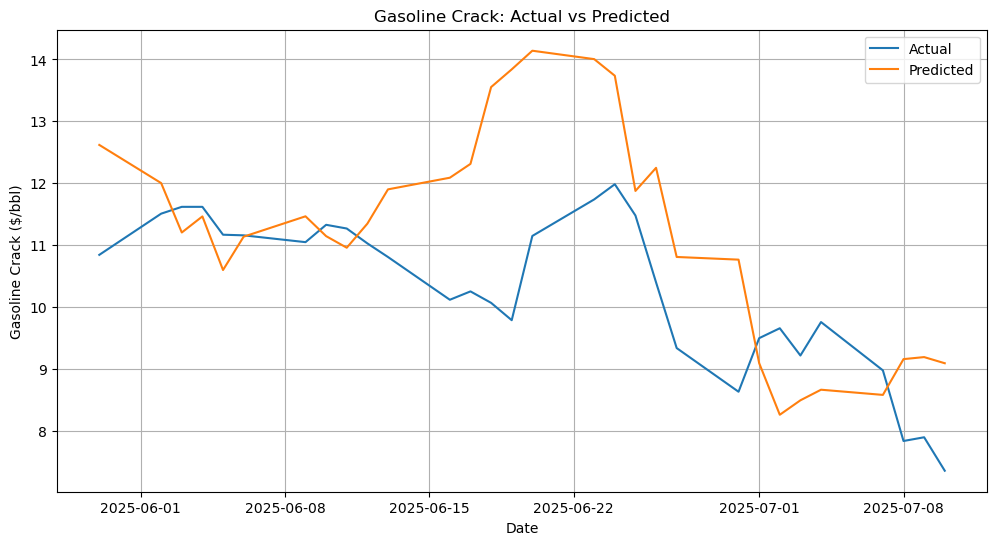

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import matplotlib.pyplot as plt

# --- Feature Engineering Function ---
def enhanced_feature_engineering(df):
    df_feat = df.copy()
    df_feat['day_of_week'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month
    df_feat['is_month_end'] = df_feat.index.is_month_end.astype(int)
    
    # Spreads if columns exist
    if all(col in df_feat.columns for col in ['Brent', 'Dubai']):
        df_feat['Brent_Dubai_Spread'] = df_feat['Brent'] - df_feat['Dubai']
        df_feat['Brent_Dubai_Spread_lag_1'] = df_feat['Brent_Dubai_Spread'].shift(1)
    
    if all(col in df_feat.columns for col in ['Gasoline', 'Naphtha']):
        df_feat['Gasoline_Naphtha_Spread'] = df_feat['Gasoline'] - df_feat['Naphtha']
        df_feat['Gasoline_Naphtha_Spread_lag_1'] = df_feat['Gasoline_Naphtha_Spread'].shift(1)
    
    # Polynomial and lag features for key variables
    key_vars = ['Gasoline_Inventory', 'AP Gasoline Demand', 'Utilisation Rate']
    for var in key_vars:
        if var in df_feat.columns:
            df_feat[f'{var}_lag_1'] = df_feat[var].shift(1)
            df_feat[f'{var}_lag_2'] = df_feat[var].shift(2)
            df_feat[f'{var}_lag_3'] = df_feat[var].shift(3)
            df_feat[f'{var}_roll_mean_7'] = df_feat[var].shift(1).rolling(window=7).mean()
            df_feat[f'{var}_roll_std_7'] = df_feat[var].shift(1).rolling(window=7).std()
            df_feat[f'{var}_sq'] = df_feat[var] ** 2
            df_feat[f'{var}_diff_1'] = df_feat[var].diff(1)

    # Lag features for other columns
    other_cols = ['Dubai', 'Brent', 'Naphtha', 'Gasoline', 'Refinery Run',
                  'Singapore 92 RON Timespread M1/M2  ', 'Asia Balance', 'Ethanol', 'Seasonal']
    for col in other_cols:
        if col in df_feat.columns:
            df_feat[f'{col}_lag_1'] = df_feat[col].shift(1)

    # Fill missing values
    df_feat = df_feat.ffill().bfill()
    return df_feat

# --- Load data ---
df = pd.read_excel("Gasoline cracks Linked.xlsm", parse_dates=["Date"])
df.set_index("Date", inplace=True)

# --- Feature engineering ---
df_feat = enhanced_feature_engineering(df)

# --- Prepare features and target ---
target = 'Gasoline_Crack'
feature_cols = [col for col in df_feat.columns if col != target]

# Drop rows with NA (due to lags)
df_feat.dropna(subset=feature_cols + [target], inplace=True)

# --- Train/test split ---
train = df_feat.iloc[:-30]
test = df_feat.iloc[-30:]

X_train = train[feature_cols]
y_train = train[target]
X_test = test[feature_cols]
y_test = test[target]

# --- XGBoost model and hyperparameter tuning ---
param_dist = {
    'max_depth': [3,4,5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

tscv = TimeSeriesSplit(n_splits=3)

rs = RandomizedSearchCV(xgb_model, param_dist, n_iter=20, scoring='neg_mean_squared_error',
                        cv=tscv, verbose=1, random_state=42, n_jobs=-1)

rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)

# Train final model
final_model = xgb.XGBRegressor(**rs.best_params_, objective='reg:squarederror', random_state=42)
final_model.fit(X_train, y_train)

# Predict test
y_pred = final_model.predict(X_test)

# Metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = np.mean(np.abs(y_test - y_pred))
r2 = r2_score(y_test, y_pred)

# Directional accuracy
pred_diff = np.sign(y_pred[1:] - y_pred[:-1])
test_diff = np.sign(y_test.values[1:] - y_test.values[:-1])
direction_acc = np.mean(pred_diff == test_diff)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")
print(f"Directional Accuracy: {direction_acc*100:.2f}%")

# --- Plot actual vs predicted ---
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title("Gasoline Crack: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Gasoline Crack ($/bbl)")
plt.legend()
plt.grid(True)
plt.show()


23:53:54 - cmdstanpy - INFO - Chain [1] start processing
23:53:54 - cmdstanpy - INFO - Chain [1] done processing


Horizon 1 day - Best Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Horizon 2 day - Best Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Horizon 3 day - Best Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Horizon 4 day - Best Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Horizon 5 day - Best Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Horizon 6 day - Best Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Hori

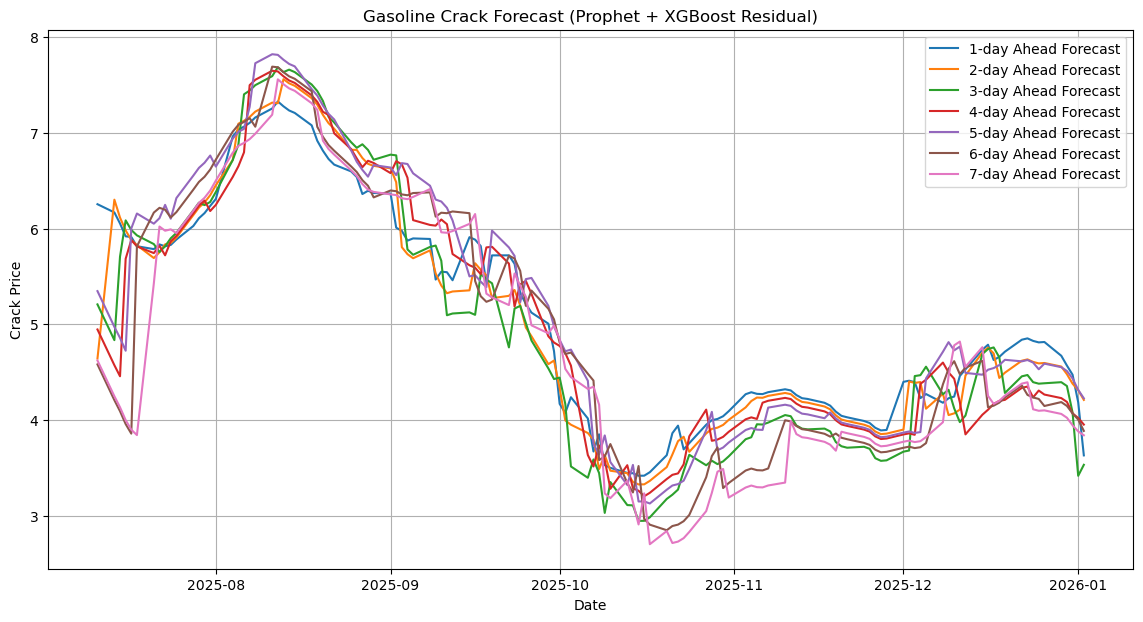

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap

# --- 1. Feature Engineering Function ---
def feature_engineering(df):
    df_feat = df.copy()
    df_feat['day_of_week'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month
    df_feat['is_month_end'] = df_feat.index.is_month_end.astype(int)
    
    # Example spreads
    if {'Brent', 'Dubai'}.issubset(df_feat.columns):
        df_feat['Brent_Dubai_Spread'] = df_feat['Brent'] - df_feat['Dubai']
    
    # Lag and rolling features for key vars
    key_vars = ['Gasoline_Crack', 'Brent', 'Dubai', 'Naphtha', 'Gasoline_Inventory', 'Utilisation Rate']
    for var in key_vars:
        if var in df_feat.columns:
            df_feat[f'{var}_lag1'] = df_feat[var].shift(1)
            df_feat[f'{var}_roll7_mean'] = df_feat[var].shift(1).rolling(7).mean()
            df_feat[f'{var}_roll7_std'] = df_feat[var].shift(1).rolling(7).std()
            df_feat[f'{var}_diff1'] = df_feat[var].diff(1)

    df_feat = df_feat.ffill().bfill()
    return df_feat

# --- 2. Load historical data and feature engineer ---
df = pd.read_excel('Gasoline cracks Linked.xlsm', parse_dates=['Date'])
df.set_index('Date', inplace=True)
df_feat = feature_engineering(df)

# --- 3. Prepare multi-step ahead targets ---
horizon = 7
for i in range(1, horizon + 1):
    df_feat[f'crack_t_plus_{i}'] = df_feat['Gasoline_Crack'].shift(-i)
df_feat.dropna(inplace=True)

# --- 4. Split train/test ---
test_days = 30
train_df = df_feat.iloc[:-test_days].copy()   # <- add .copy()
test_df = df_feat.iloc[-test_days:].copy()    # <- add .copy()

# Define feature columns excluding target and forward targets
feature_cols = [col for col in df_feat.columns 
                if (not col.startswith('crack_t_plus_')) and
                   (col != 'Gasoline_Crack')]

# --- 5. Fit Prophet model on historical cracks ---
prophet_df = df.reset_index()[['Date', 'Gasoline_Crack']].rename(columns={'Date':'ds', 'Gasoline_Crack':'y'})
prophet_model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
prophet_model.fit(prophet_df)

# Get Prophet forecast on historical dates
historical_forecast = prophet_model.predict(prophet_df).set_index('ds')

# Add prophet components and residual to train_df
train_df.loc[:, 'prophet_trend'] = historical_forecast.loc[train_df.index, 'trend']
train_df.loc[:, 'prophet_weekly'] = historical_forecast.loc[train_df.index, 'weekly']
train_df.loc[:, 'prophet_yearly'] = historical_forecast.loc[train_df.index, 'yearly']
train_df.loc[:, 'residual'] = train_df['Gasoline_Crack'] - (
    train_df['prophet_trend'] + train_df['prophet_weekly'] + train_df['prophet_yearly']
)

# Residual = actual crack - prophet prediction
train_df['residual'] = train_df['Gasoline_Crack'] - (
    train_df['prophet_trend'] + train_df['prophet_weekly'] + train_df['prophet_yearly']
)

# --- 6. Train XGBoost models on residuals for each forecast horizon ---
param_dist = {
    'max_depth': [3,4,5],
    'learning_rate': [0.01,0.05,0.1],
    'n_estimators': [100,200],
    'subsample': [0.6,0.8],
    'colsample_bytree': [0.6,0.8],
    'reg_alpha': [0,0.1],
    'reg_lambda': [1,2]
}
tscv = TimeSeriesSplit(n_splits=3)
models = {}

for i in range(1, horizon + 1):
    target = f'crack_t_plus_{i}'
    
    # residual target = (future crack) - (future prophet forecast)
    y_train = train_df[target] - (
        train_df['prophet_trend'] + train_df['prophet_weekly'] + train_df['prophet_yearly']
    ).shift(-i)
    
    # Align X_train with y_train after removing NaNs
    valid_idx = y_train.dropna().index
    X_train_i = train_df.loc[valid_idx, feature_cols]
    y_train_i = y_train.loc[valid_idx]

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    rs = RandomizedSearchCV(xgb_model, param_dist, n_iter=10, cv=tscv,
                            scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    rs.fit(X_train_i, y_train_i)

    best_model = xgb.XGBRegressor(**rs.best_params_, objective='reg:squarederror', random_state=42)
    best_model.fit(X_train_i, y_train_i)
    models[i] = best_model

    print(f"Horizon {i} day - Best Params: {rs.best_params_}")

# --- 7. Prepare future inputs with seeding for lag features ---

future_inputs = pd.read_excel('Future input.xlsm', parse_dates=['Date'])
future_inputs.set_index('Date', inplace=True)
future_inputs = future_inputs[future_inputs.index.dayofweek < 5]  # Keep only weekdays

# To calculate lag/rolling features on future data, seed with last 7 rows of historical df_feat
seed_len = 7
seed_df = df_feat.iloc[-seed_len:][feature_cols]
future_feat = pd.concat([seed_df, future_inputs], axis=0)

# Apply feature engineering on combined data
future_feat = feature_engineering(future_feat)

# Only keep the future dates (drop seed rows)
future_feat = future_feat.loc[future_inputs.index]

# Make sure feature_cols exist in future_feat (filter)
feature_cols_pred = [col for col in feature_cols if col in future_feat.columns]

# --- 8. Get Prophet forecast for future dates ---
future_prophet_df = future_inputs.reset_index().rename(columns={'Date':'ds'})
future_prophet_forecast = prophet_model.predict(future_prophet_df).set_index('ds')

# --- 9. Make final forecast combining Prophet + residuals ---
final_forecast = pd.DataFrame(index=future_feat.index)
final_forecast = final_forecast[final_forecast.index.dayofweek < 5]  # Weekdays only
final_forecast['prophet'] = future_prophet_forecast['trend'] + future_prophet_forecast['weekly'] + future_prophet_forecast['yearly']

for i in range(1, horizon + 1):
    # Shift features backward by i-1 days to align for prediction
    X_pred = future_feat[feature_cols_pred].shift(i-1).fillna(method='ffill').fillna(0)
    residual_pred = models[i].predict(X_pred)
    final_forecast[f'forecast_t_plus_{i}'] = final_forecast['prophet'] + residual_pred

# --- 10. Plot forecasts ---
plt.figure(figsize=(14,7))
for i in range(1, horizon+1):
    plt.plot(final_forecast.index, final_forecast[f'forecast_t_plus_{i}'], label=f'{i}-day Ahead Forecast')
plt.title('Gasoline Crack Forecast (Prophet + XGBoost Residual)')
plt.xlabel('Date')
plt.ylabel('Crack Price')
plt.legend()
plt.grid()
plt.show()


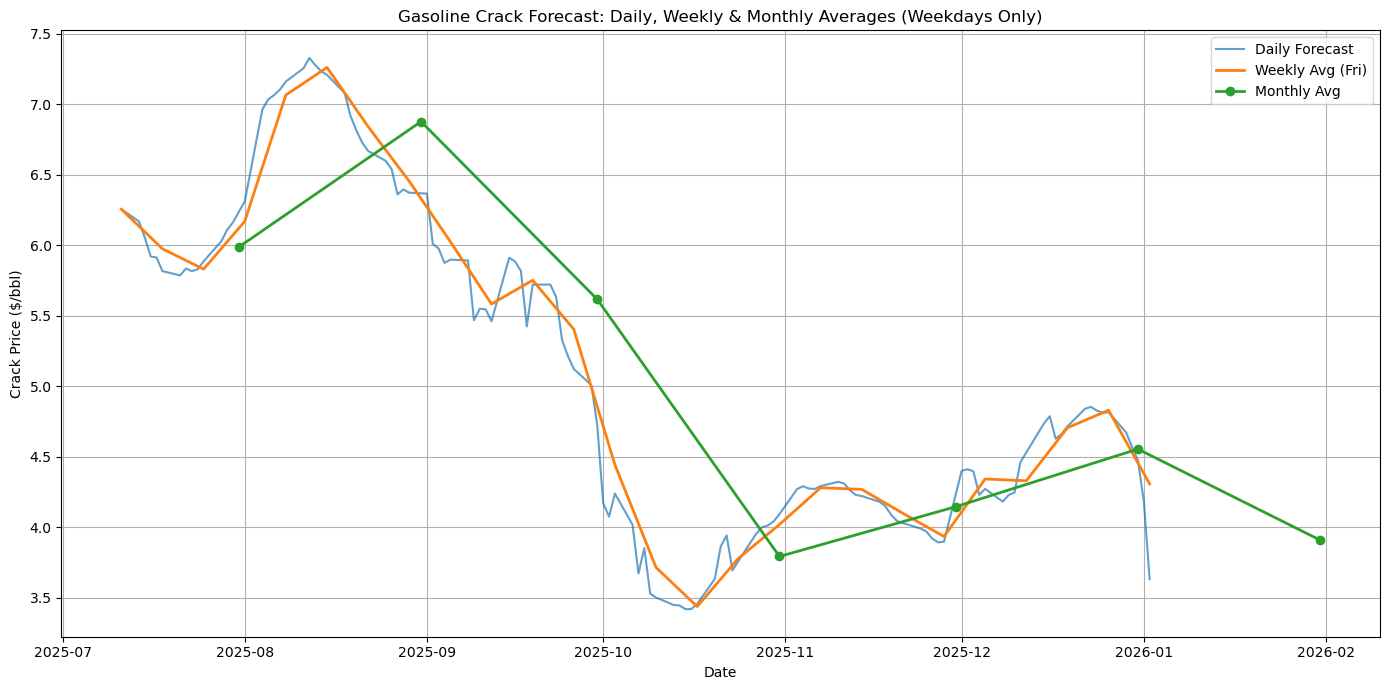

In [8]:
# -----------------------------------------------------------
# Make an explicit alias so the plot code is self‑contained
# -----------------------------------------------------------
final_forecast_daily = final_forecast.copy()        # or rename as you like

# --- Weekly & Monthly Aggregations -------------------------
daily_series   = final_forecast_daily['forecast_t_plus_1']

weekly_avg   = daily_series.resample('W-FRI').mean()      # avg ending each Fri
# If you want a rolling window instead, uncomment the next line:
# weekly_avg = daily_series.rolling(window=5).mean()      # 5 weekdays

monthly_avg  = daily_series.resample('M').mean()          # calendar month‑end

# --- Plot -------------------------------------------------
plt.figure(figsize=(14, 7))
plt.plot(daily_series.index, daily_series,
         label='Daily Forecast', alpha=0.7)
plt.plot(weekly_avg.index, weekly_avg,
         label='Weekly Avg (Fri)', linewidth=2)
plt.plot(monthly_avg.index, monthly_avg,
         label='Monthly Avg', linewidth=2, marker='o')

plt.title('Gasoline Crack Forecast: Daily, Weekly & Monthly Averages (Weekdays Only)')
plt.xlabel('Date'); plt.ylabel('Crack Price ($/bbl)')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()





Horizon 1 day(s) ahead - Test Metrics:
  RMSE: 2.2466
  MAE:  2.1941
  R²:   -5.3991
  Directional Accuracy: 64.29%
--------------------------------------------------
Top Feature Importances for 1-day Model:
  Gasoline_Crack_lag1: 0.1561
  Dubai_roll7_mean: 0.0791
  Singapore 92 RON Timespread M1/M2 : 0.0741
  Gasoline_Crack_roll7_mean: 0.0723
  Gasoline_Inventory: 0.0502
  Utilisation Rate_lag1: 0.0448
  Gasoline_Inventory_lag1: 0.0446
  Refinery Run: 0.0386
  Gasoline_Crack_roll7_std: 0.0379
  Brent_roll7_mean: 0.0360


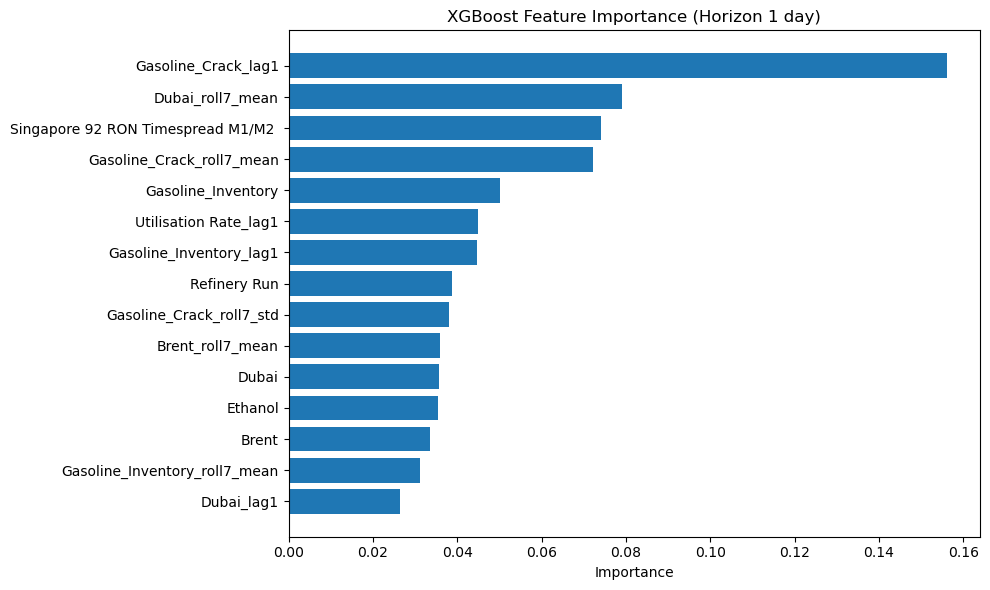


Horizon 2 day(s) ahead - Test Metrics:
  RMSE: 2.3552
  MAE:  2.1340
  R²:   -6.2427
  Directional Accuracy: 33.33%
--------------------------------------------------
Top Feature Importances for 2-day Model:
  Gasoline_Crack_lag1: 0.1445
  Gasoline_Crack_roll7_mean: 0.0825
  Dubai_roll7_mean: 0.0751
  Singapore 92 RON Timespread M1/M2 : 0.0584
  Dubai_lag1: 0.0495
  Gasoline_Inventory_lag1: 0.0481
  Utilisation Rate_lag1: 0.0473
  Gasoline_Inventory: 0.0438
  Dubai: 0.0403
  Refinery Run: 0.0358


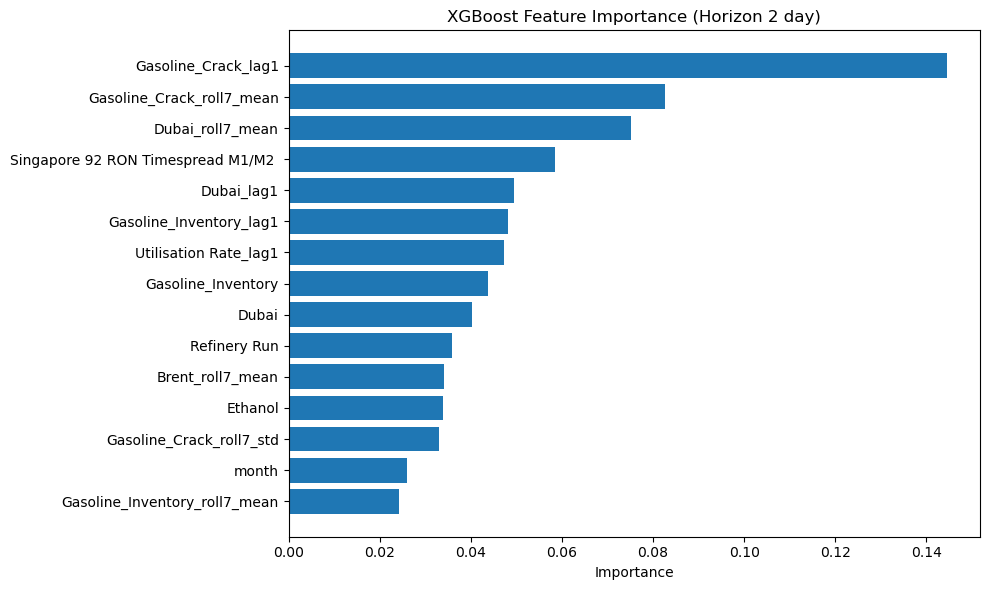


Horizon 3 day(s) ahead - Test Metrics:
  RMSE: 2.1350
  MAE:  1.8746
  R²:   -5.3076
  Directional Accuracy: 57.69%
--------------------------------------------------
Top Feature Importances for 3-day Model:
  Gasoline: 0.1249
  Gasoline_Crack_lag1: 0.1216
  Gasoline_Crack_roll7_mean: 0.0632
  Gasoline_Crack_roll7_std: 0.0585
  Dubai_roll7_mean: 0.0536
  Gasoline_Inventory_lag1: 0.0482
  Utilisation Rate_lag1: 0.0425
  Ethanol: 0.0424
  Dubai_lag1: 0.0412
  Singapore 92 RON Timespread M1/M2 : 0.0406


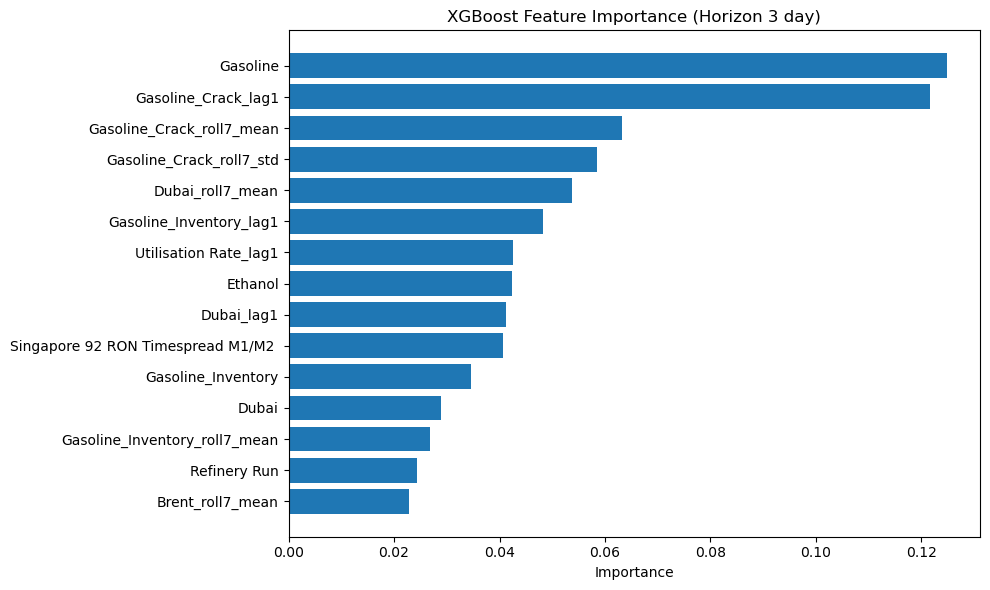


Horizon 4 day(s) ahead - Test Metrics:
  RMSE: 2.3662
  MAE:  2.1889
  R²:   -7.2974
  Directional Accuracy: 56.00%
--------------------------------------------------
Top Feature Importances for 4-day Model:
  Gasoline_Crack_lag1: 0.1362
  Gasoline: 0.1098
  Dubai_lag1: 0.0662
  Gasoline_Inventory_lag1: 0.0523
  Gasoline_Crack_roll7_mean: 0.0518
  Singapore 92 RON Timespread M1/M2 : 0.0500
  Dubai_roll7_mean: 0.0422
  Gasoline_Inventory: 0.0393
  Ethanol: 0.0374
  Gasoline_Crack_roll7_std: 0.0368


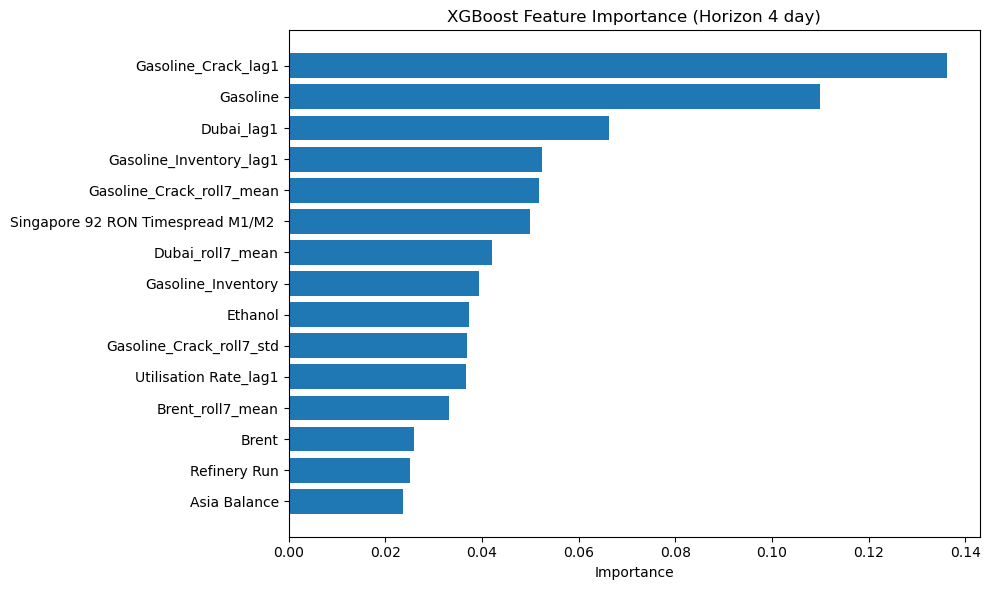


Horizon 5 day(s) ahead - Test Metrics:
  RMSE: 2.2523
  MAE:  2.0879
  R²:   -6.4916
  Directional Accuracy: 54.17%
--------------------------------------------------
Top Feature Importances for 5-day Model:
  Gasoline: 0.1543
  Gasoline_Crack_lag1: 0.1297
  Gasoline_Inventory_lag1: 0.0609
  Dubai_lag1: 0.0448
  Singapore 92 RON Timespread M1/M2 : 0.0426
  Ethanol: 0.0422
  Dubai_roll7_mean: 0.0411
  Gasoline_Crack_roll7_mean: 0.0391
  Gasoline_Crack_roll7_std: 0.0335
  Utilisation Rate_lag1: 0.0330


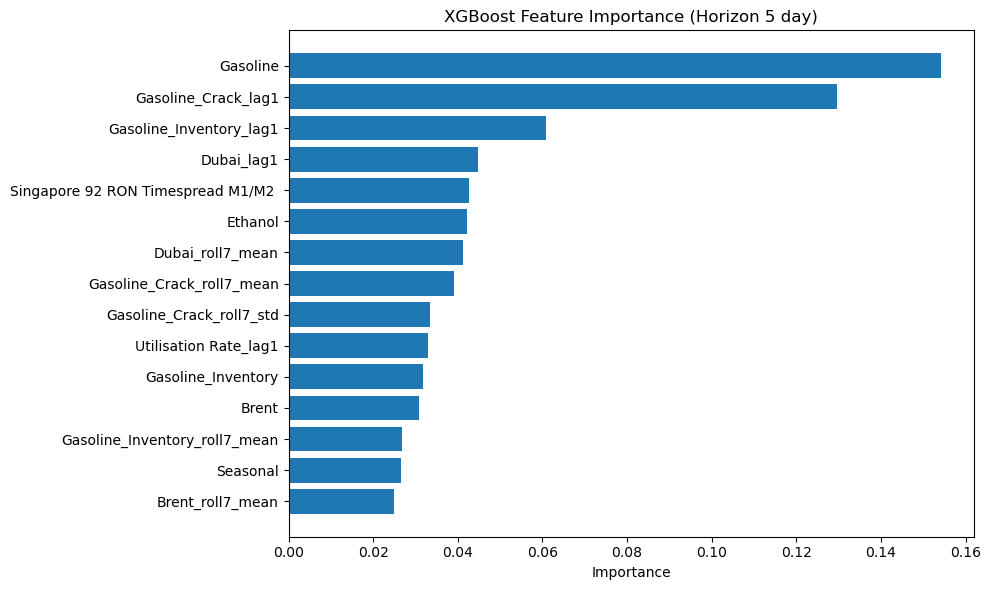


Horizon 6 day(s) ahead - Test Metrics:
  RMSE: 2.5603
  MAE:  2.2232
  R²:   -8.4897
  Directional Accuracy: 39.13%
--------------------------------------------------
Top Feature Importances for 6-day Model:
  Gasoline: 0.2103
  Gasoline_Crack_lag1: 0.1210
  Gasoline_Inventory_lag1: 0.0750
  Singapore 92 RON Timespread M1/M2 : 0.0442
  Ethanol: 0.0427
  Dubai_roll7_mean: 0.0396
  Utilisation Rate_lag1: 0.0380
  Gasoline_Crack_roll7_mean: 0.0357
  Gasoline_Inventory: 0.0313
  Brent_roll7_mean: 0.0284


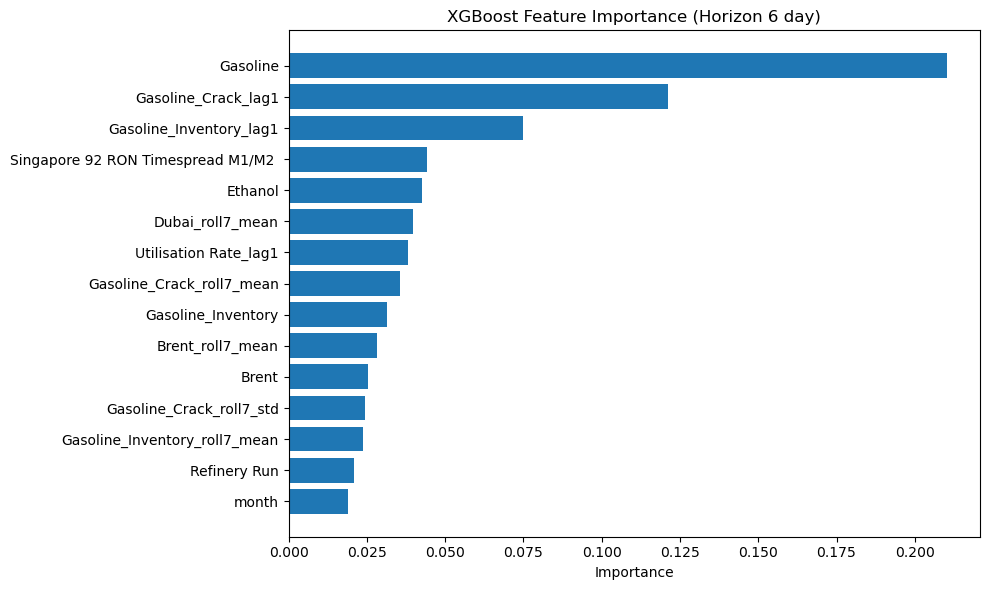


Horizon 7 day(s) ahead - Test Metrics:
  RMSE: 2.7732
  MAE:  2.4208
  R²:   -9.6702
  Directional Accuracy: 54.55%
--------------------------------------------------
Top Feature Importances for 7-day Model:
  Gasoline_Crack_lag1: 0.1374
  Gasoline: 0.1110
  Gasoline_Inventory: 0.0606
  Gasoline_Inventory_lag1: 0.0561
  Singapore 92 RON Timespread M1/M2 : 0.0428
  Gasoline_Crack_roll7_mean: 0.0419
  Ethanol: 0.0399
  Dubai_roll7_mean: 0.0395
  Utilisation Rate_lag1: 0.0369
  Gasoline_Crack_roll7_std: 0.0347


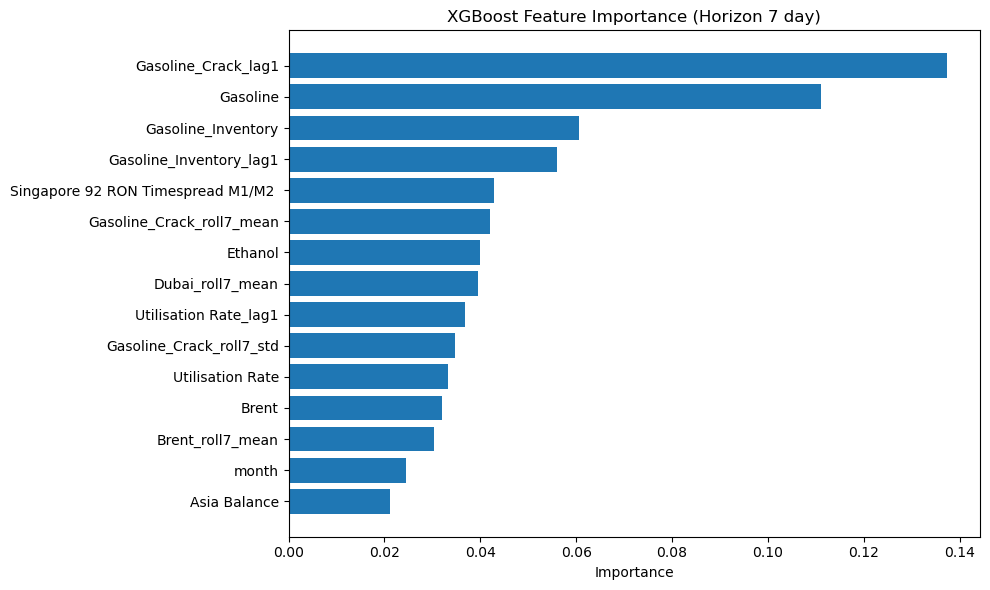

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

X_train_dict = {}  # Store for SHAP use

for i in range(1, horizon + 1):
    target = f'crack_t_plus_{i}'

    y_true = test_df[target].dropna()
    X_test = test_df[feature_cols].shift(i - 1).loc[y_true.index].fillna(method='ffill').fillna(0)

    residual_pred = models[i].predict(X_test)

    prophet_forecast_df = test_df.loc[y_true.index].reset_index().rename(columns={'Date': 'ds'})
    prophet_pred_full = prophet_model.predict(prophet_forecast_df).set_index('ds')
    prophet_pred = (prophet_pred_full['trend'] + 
                    prophet_pred_full['weekly'] + 
                    prophet_pred_full['yearly']).shift(-i).loc[y_true.index]

    valid_idx = y_true.index.intersection(prophet_pred.dropna().index)

    y_true_clean = y_true.loc[valid_idx]
    y_pred_clean = prophet_pred.loc[valid_idx] + residual_pred[:len(valid_idx)]

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)

    # Directional accuracy
    direction_true = y_true_clean.diff().dropna() > 0
    direction_pred = y_pred_clean.diff().dropna() > 0
    directional_acc = (direction_true == direction_pred).mean() * 100

    print(f"\nHorizon {i} day(s) ahead - Test Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  Directional Accuracy: {directional_acc:.2f}%")
    print('-' * 50)

    # Feature importance
    importances = models[i].feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = np.array(feature_cols)[sorted_idx]
    sorted_importances = importances[sorted_idx]

    print(f"Top Feature Importances for {i}-day Model:")
    for f, imp in zip(sorted_features[:10], sorted_importances[:10]):
        print(f"  {f}: {imp:.4f}")

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features[:15][::-1], sorted_importances[:15][::-1])
    plt.title(f'XGBoost Feature Importance (Horizon {i} day)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    # SHAP (only for 1-day model to save time)
    if i == 1:
        # Use previously stored training set if available
        X_train_sample = X_train_dict.get(i, None)
        if X_train_sample is not None:
            explainer = shap.Explainer(models[i])
            shap_values = explainer(X_train_sample)
            shap.summary_plot(shap_values, X_train_sample)



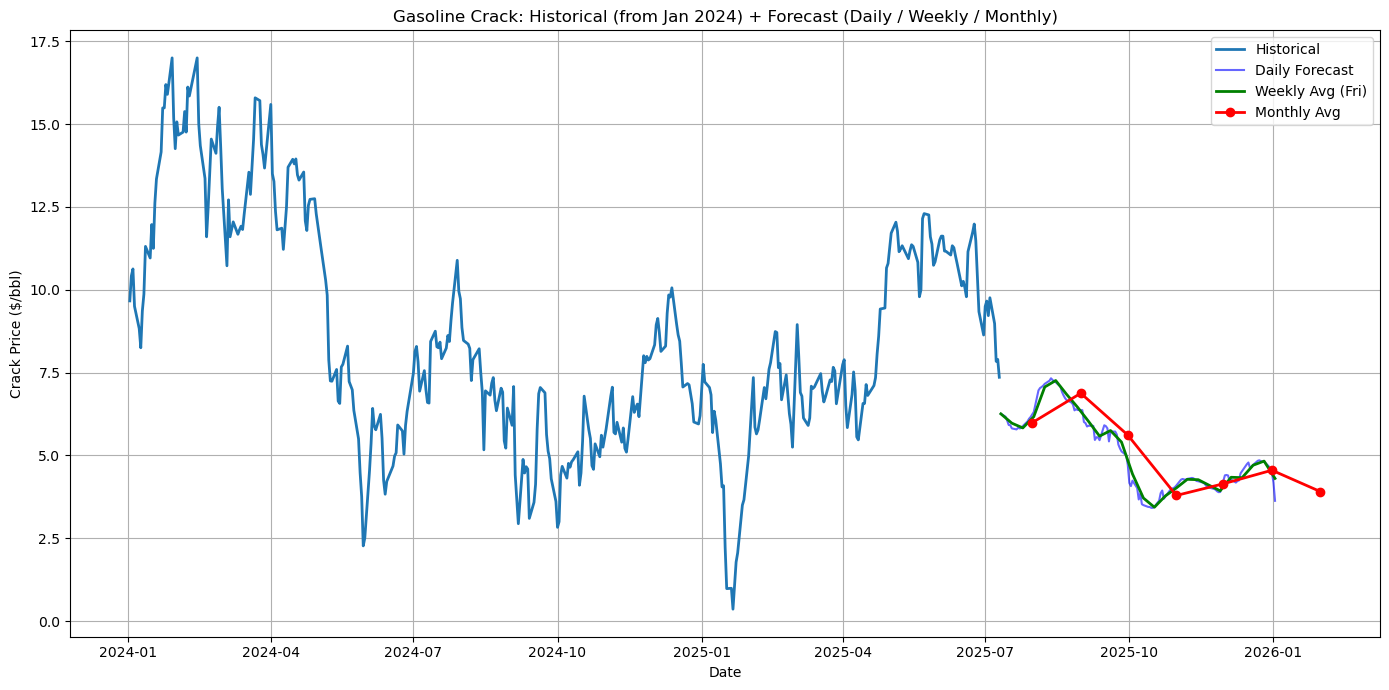

In [13]:
# --- Filter historical data from Jan 2024 ---
historical_2024 = df.loc[df.index >= '2024-01-01', 'Gasoline_Crack']

# --- Create rolling & resampled forecast averages ---
daily_forecast = final_forecast['forecast_t_plus_1']
weekly_avg = daily_forecast.resample('W-FRI').mean()
monthly_avg = daily_forecast.resample('M').mean()

# --- Plot all together ---
plt.figure(figsize=(14, 7))

# Plot historical crack
plt.plot(historical_2024.dropna().index, historical_2024.dropna(), label='Historical', linewidth=2)

# Forecast lines
plt.plot(daily_forecast.index, daily_forecast, label='Daily Forecast', alpha=0.6, color='blue')
plt.plot(weekly_avg.index, weekly_avg, label='Weekly Avg (Fri)', linewidth=2, color='green')
plt.plot(monthly_avg.index, monthly_avg, label='Monthly Avg', linewidth=2, color='red', marker='o')

plt.title('Gasoline Crack: Historical (from Jan 2024) + Forecast (Daily / Weekly / Monthly)')
plt.xlabel('Date'); plt.ylabel('Crack Price ($/bbl)')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


In [15]:
# Daily forecast (already exists)
daily_forecast = final_forecast['forecast_t_plus_1'].copy()

# Weekly forecast – average every Friday
weekly_forecast = daily_forecast.resample('W-FRI').mean()

# Monthly forecast – average for each calendar month
monthly_forecast = daily_forecast.resample('M').mean()


In [16]:
print("===== Daily Forecast =====")
print(daily_forecast.round(2).to_frame(name='Forecast'))

print("\n===== Weekly Forecast (Fri avg) =====")
print(weekly_forecast.round(2).to_frame(name='Forecast'))

print("\n===== Monthly Forecast =====")
print(monthly_forecast.round(2).to_frame(name='Forecast'))


===== Daily Forecast =====
            Forecast
Date                
2025-07-11      6.26
2025-07-14      6.17
2025-07-15      6.05
2025-07-16      5.92
2025-07-17      5.91
...              ...
2025-12-29      4.67
2025-12-30      4.57
2025-12-31      4.47
2026-01-01      4.19
2026-01-02      3.63

[126 rows x 1 columns]

===== Weekly Forecast (Fri avg) =====
            Forecast
Date                
2025-07-11      6.26
2025-07-18      5.97
2025-07-25      5.83
2025-08-01      6.17
2025-08-08      7.07
2025-08-15      7.26
2025-08-22      6.84
2025-08-29      6.45
2025-09-05      6.03
2025-09-12      5.58
2025-09-19      5.75
2025-09-26      5.40
2025-10-03      4.44
2025-10-10      3.71
2025-10-17      3.44
2025-10-24      3.78
2025-10-31      4.02
2025-11-07      4.28
2025-11-14      4.27
2025-11-21      4.10
2025-11-28      3.93
2025-12-05      4.34
2025-12-12      4.33
2025-12-19      4.70
2025-12-26      4.83
2026-01-02      4.31

===== Monthly Forecast =====
            Forecas